In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
# Dataset path and view possible targets
dataset_path = 'C:\\Users\Greg\ML\Technical\project\git2\monophonic_classfication_cnn\padded'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

A#3
A#4
A3
A4
B3
B4
C#3
C#4
C3
C4
D#3
D#4
D3
D4
E3
E4
F#3
F#4
F3
F4
G3
G4
_background_noise_


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)
train_target = ['A3', 'A#3', 'B3', 'C3', 'C#3','D3', 'D#3', 'E3', 'F3', 'F#3','G3','A4']

['A#3', 'A#4', 'A3', 'A4', 'B3', 'B4', 'C#3', 'C#4', 'C3', 'C4', 'D#3', 'D#4', 'D3', 'D4', 'E3', 'E4', 'F#3', 'F#4', 'F3', 'F4', 'G3', 'G4', '_background_noise_']


In [4]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)
print(train_target)

['A#3', 'A#4', 'A3', 'A4', 'B3', 'B4', 'C#3', 'C#4', 'C3', 'C4', 'D#3', 'D#4', 'D3', 'D4', 'E3', 'E4', 'F#3', 'F#4', 'F3', 'F4', 'G3', 'G4']
['A3', 'A#3', 'B3', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'A4']


In [5]:
# See how many files are in each
num_samples = 0
for target in train_target:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

59
62
62
41
44
50
50
51
49
52
59
65
Total samples: 644


In [6]:
# Settings
target_list = train_target
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 44100
num_mfcc = 16
len_mfcc = 16

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    #print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

In [8]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]), array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 

In [9]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [10]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [11]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))


644
644


In [12]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [13]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]


In [14]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=11290,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [16]:
# Create Test 
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    # Create path from given filename and target item
    path = join(dataset_path, train_target[int(y_orig_train[index])], 
                filename)
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


C:\Users\Greg\ML\Technical\project\git2\monophonic_classfication_cnn\padded\E3\padVa-ord-E3-pp-4c-T17u.wav
MFCCs: [[-6.93679526e+01 -6.73805709e+01 -6.54835998e+01 -6.40660502e+01
  -6.34885621e+01 -6.34670006e+01 -6.37909349e+01 -6.31722818e+01
  -6.23575213e+01 -6.23337731e+01 -6.23412168e+01 -6.19982518e+01
  -6.18574333e+01 -6.16693599e+01 -6.10737263e+01 -6.05756410e+01]
 [ 1.39934140e+01  1.49188112e+01  1.59343789e+01  1.68607675e+01
   1.72022943e+01  1.71004599e+01  1.68461365e+01  1.70148478e+01
   1.73488314e+01  1.73885014e+01  1.72849531e+01  1.73468133e+01
   1.75159162e+01  1.76487479e+01  1.76569764e+01  1.76478677e+01]
 [ 1.69375804e+00  8.78705609e-01  3.76309886e-01  3.55402266e-02
  -3.30806314e-01 -4.51747329e-01 -6.69336010e-02  1.17101015e-01
   2.32281322e-02  6.52357073e-02 -1.35744414e-01 -6.94821713e-01
  -8.62244258e-01 -8.94842902e-01 -1.23359025e+00 -1.47007485e+00]
 [-1.92385359e+00 -1.71673468e+00 -1.89427960e+00 -2.33680122e+00
  -2.76303532e+00 -3.0132

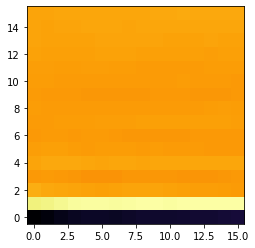

In [18]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 10

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

print(path)
# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Removed percentage: 0.0
Removed percentage: 0.0
Removed percentage: 0.0


In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [22]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [23]:
len(feature_sets['x_train'])

516

In [24]:
print(feature_sets['y_val'])

[ 1.  8. 10.  8.  7. 10.  4.  5.  1.  1.  0.  6.  5.  8.  2.  0.  0. 11.
 11.  7. 11. 11. 11. 10.  6. 10.  4.  5.  7.  4.  5.  1.  2.  0.  7.  5.
  8.  7.  7.  3.  4.  1.  0.  9.  5. 10.  1. 10.  9.  6.  9.  7.  0.  1.
  4.  2.  0.  8.  0.  2.  1.  2.  6.  0.]
